# Dataset Source
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing# <br>
(select "Data Folder", download "bank-additional.zip", and extract "bank-additional-full.csv").

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve, roc_auc_score, make_scorer, auc, roc_curve
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data into a pandas dataframe
data = pd.read_csv("bank-additional-full.csv", delimiter=';')

In [3]:
# See what the dataset looks like
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
# View number of (rows, columns) in the dataset
data.shape

(41188, 21)

In [6]:
# List all columns in the dataset
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [7]:
# View data types of the columns
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [8]:
# View number of rows in the dataframe
data.shape

(41188, 21)

In [9]:
data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

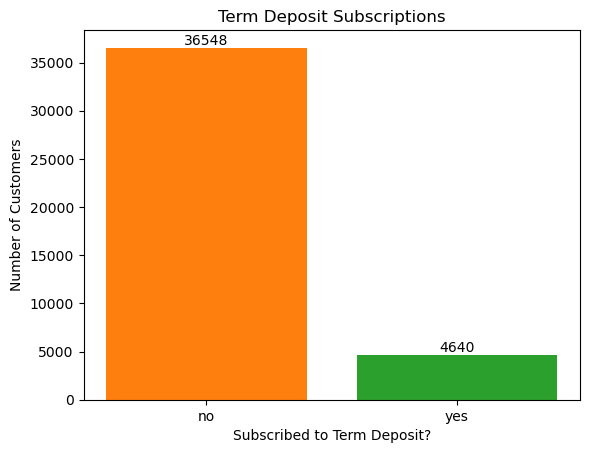

In [10]:
# Count the number of customers in each class 
counts = data['y'].value_counts()

# Create a bar chart with the counts
class_bar = plt.bar(counts.index, counts.values, color=['C1', 'C2'])

# Add labels and title
plt.xlabel('Subscribed to Term Deposit?')
plt.ylabel('Number of Customers')
plt.title('Term Deposit Subscriptions')
plt.bar_label(class_bar)

# Show the plot
plt.show()

We observe that the dataset is imbalanced where non-subscritptions ('no') and subscriptions ('yes') have about 90:10 split, respectively. Therefore, we'll balance the dataset by undersampling the majority class ('no') before training our models in order to improve performance.

In [11]:
# Check dataframe for missing values
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no missing values. However, the dataset description reveals that unavailable information is represented as 'unknown' values.

In [12]:
# Select 'unknown' values in the dataset. Doing so converts 'unknown' values to NaN.
df = data[~(data == "unknown")]
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [13]:
# View number of 'unknown' values that were convert to NaN in each column. 
df.isna().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

[Text(0, 0, '80'),
 Text(0, 0, '330'),
 Text(0, 0, '990'),
 Text(0, 0, '990'),
 Text(0, 0, '1731'),
 Text(0, 0, '8597')]

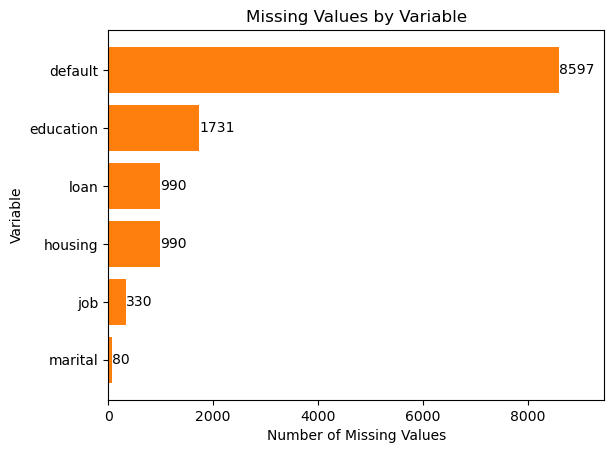

In [14]:
# Visualize missing values by variable
missing_sorted = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=True)
fig, ax = plt.subplots()
hbars = ax.barh(missing_sorted.index, missing_sorted, color=['C1'])
ax.set_xlabel('Number of Missing Values')
ax.set_ylabel('Variable')
ax.set_title('Missing Values by Variable')
ax.set_xlim(right = missing_sorted.max() * 1.1)
ax.bar_label(hbars)

In [15]:
# Drop 'unknown' values because they have no utility for predicting classification
df.dropna(inplace = True)

In [16]:
# Confirm that all unknown/NaN values have been dropped. 
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

All unknown/NaN values have been dropped.

In [17]:
# View number of rows in the dataframe after dropping rows with 'unknown' values
df.shape[0]

30488

# Balancing the dataset

In [18]:
# Select all records classified as 'yes'
yes_df = df[df['y'] == 'yes']

# Select all records classified as 'no'
no_df = df[df['y'] == 'no']

# Randomly select an equal number of records classified as 'no'
num_yes = len(yes_df)
no_df_sampled = no_df.sample(n=num_yes, random_state=42)  # using a fixed random state for reproducibility

# Combine the selected 'yes' and 'no' records into a single DataFrame
final_df = pd.concat([yes_df, no_df_sampled])

# Shuffle the order of the rows in the DataFrame
final_df = final_df.sample(frac=1, random_state=42)  # using a fixed random state for reproducibility

# Print the first few rows of the final DataFrame to verify the results
final_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
6360,52,services,married,high.school,no,no,no,telephone,may,tue,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
16133,35,services,divorced,university.degree,no,no,yes,cellular,jul,tue,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,yes
40424,27,admin.,single,university.degree,no,yes,no,cellular,aug,fri,...,2,999,0,nonexistent,-1.7,94.027,-38.3,0.905,4991.6,yes
20638,35,technician,married,university.degree,no,yes,no,cellular,aug,wed,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,yes
37332,26,student,single,professional.course,no,yes,no,cellular,aug,tue,...,2,999,1,failure,-2.9,92.201,-31.4,0.883,5076.2,yes


In [19]:
final_df['y'].value_counts()

no     3859
yes    3859
Name: y, dtype: int64

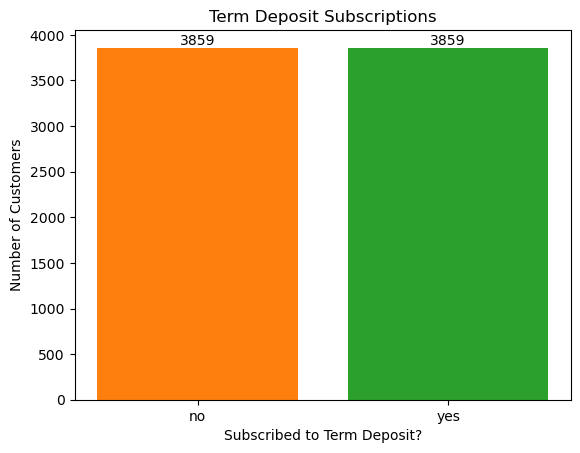

In [20]:
# Count the number of customers in each class 
counts = final_df['y'].value_counts()

# Create a bar chart with the counts
class_bar = plt.bar(counts.index, counts.values, color=['C1', 'C2'])

# Add labels and title
plt.xlabel('Subscribed to Term Deposit?')
plt.ylabel('Number of Customers')
plt.title('Term Deposit Subscriptions')
plt.bar_label(class_bar)

# Show the plot
plt.show()

The dataset is now equally balanced between the two classes.

# Classification Tree

In [21]:
# One-hot encoding for categorical variables
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
df_encoded = pd.get_dummies(final_df, columns=cat_vars)

In [22]:
# Split data into training and testing sets
X = df_encoded.drop(['y'], axis=1)
y = df_encoded['y']

X_train, X_valid, y_train , y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

In [23]:
X_train.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'default_no', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_fa

## Parameter Tuning
Classification performance will be optimized by using Grid Search to find best parameters. 'AUC' will be used as the metric to measure performance. 

In [24]:
# define AUC to be the performance metric for grid search
scoring = {'auc': make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")}

In [25]:
# # Start with an initial guess for parameters
# param_grid = {
#     'max_depth': list(range(2,10)),
#     'min_samples_split': [30, 60, 120, 240],
#     'min_samples_leaf': [30, 60, 120, 240],
#     'max_leaf_nodes': [20, 30, 40, None],
#     'min_impurity_decrease': [0, 0.01, 0.05, 0.1],
#     }
# gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, scoring = scoring, refit = 'auc', cv=5,
# n_jobs=-1)
# gridSearch.fit(X_train, y_train)
# print('Initial score: ', gridSearch.best_score_)
# print('Initial parameters: ', gridSearch.best_params_)

In [26]:
# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(5,10)),
    'min_samples_split': [100, 110, 120, 130],
    'min_samples_leaf': [20, 30, 40],
    'max_leaf_nodes': [25, 30, 35],
    }
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, scoring = scoring, refit = 'auc', cv=5,
n_jobs=-1) 
gridSearch.fit(X_train, y_train)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_

Improved score:  0.9364920551797538
Improved parameters:  {'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 20, 'min_samples_split': 110}


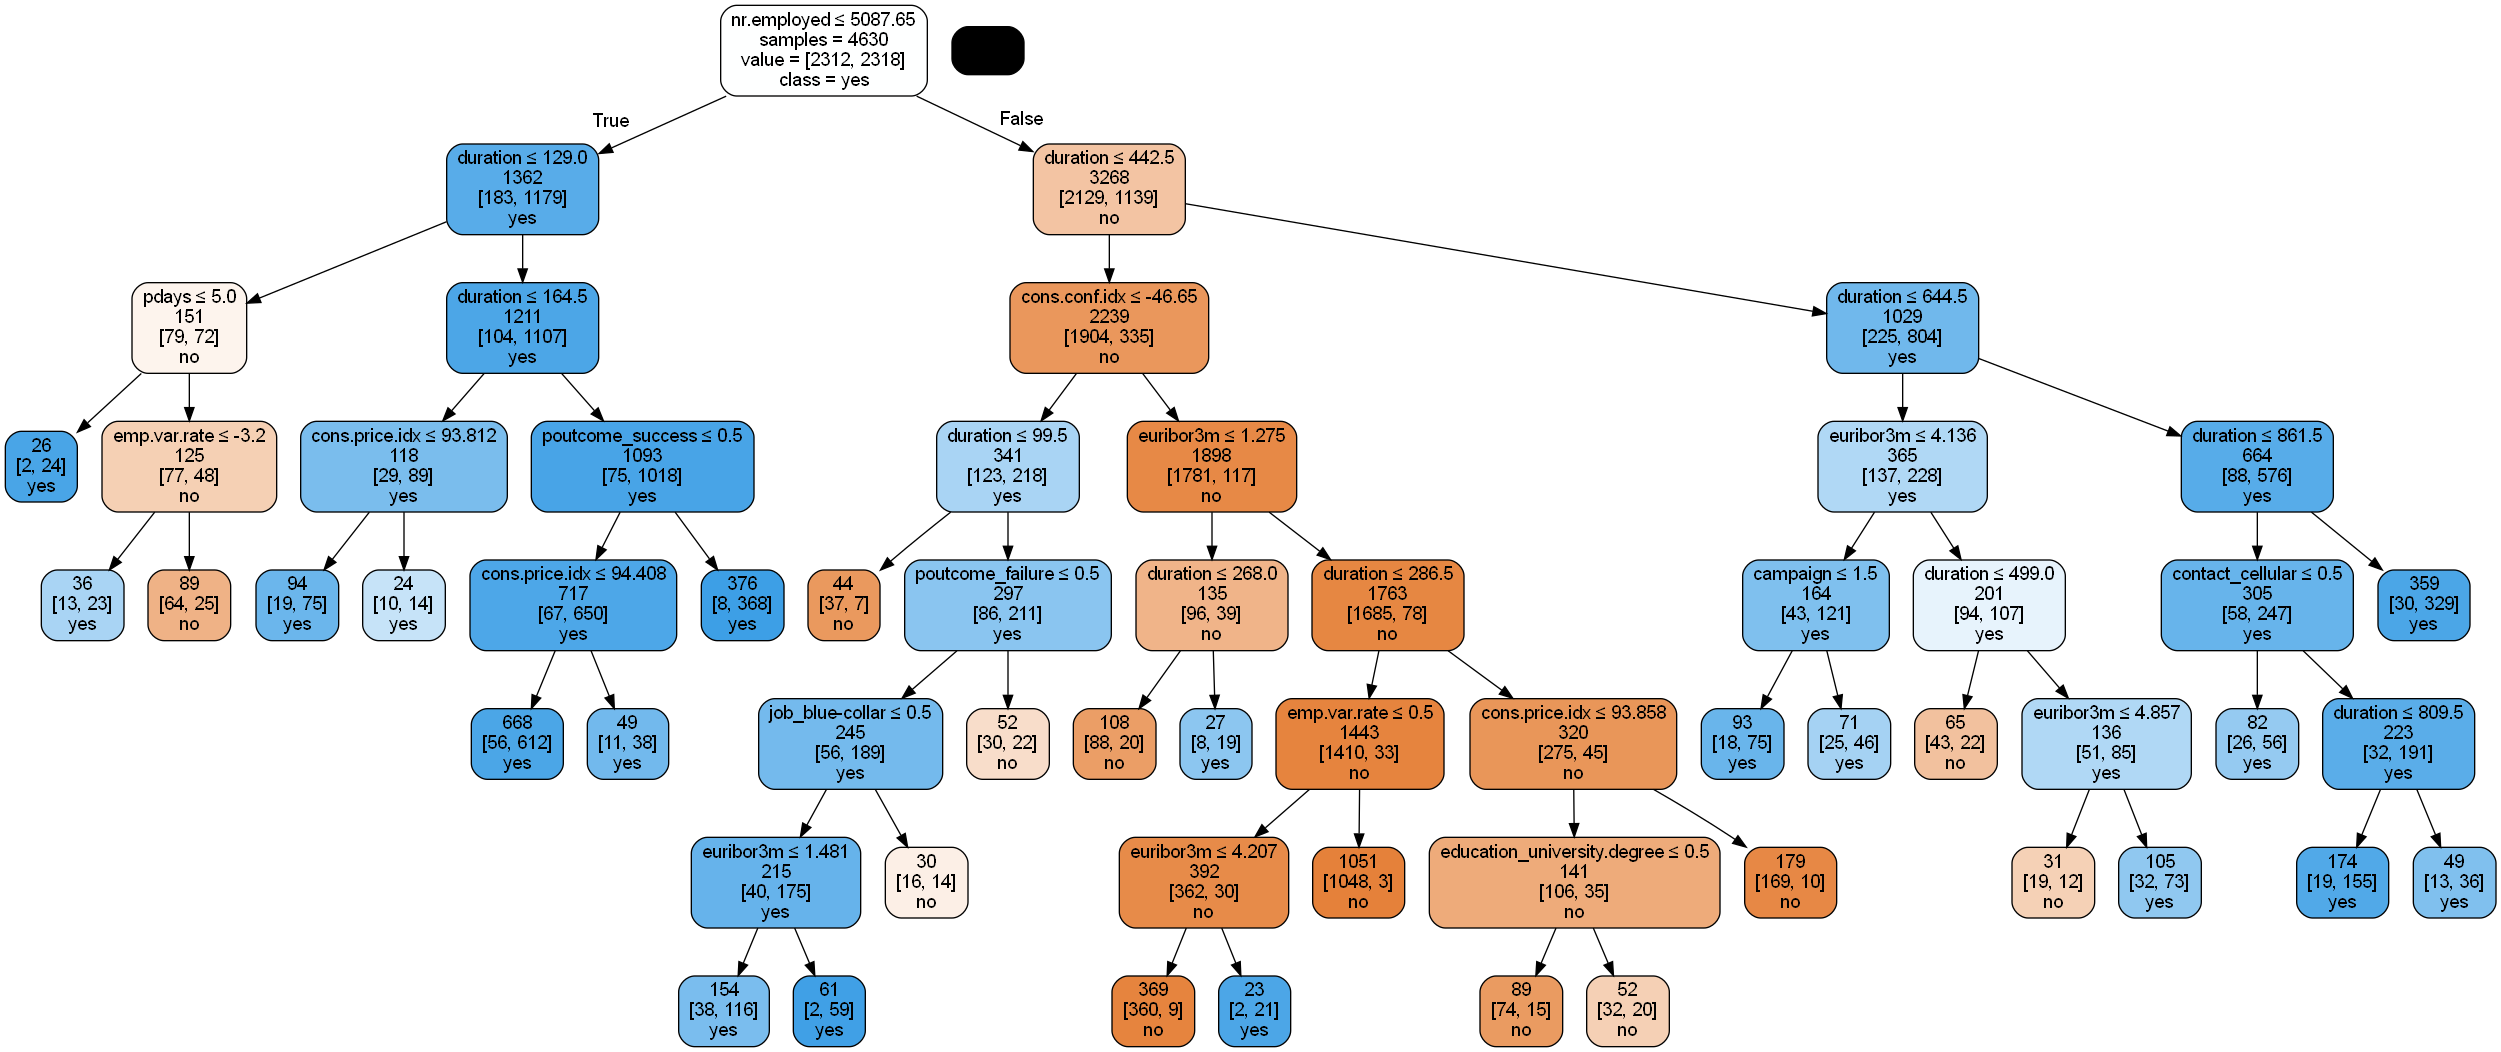

In [27]:
# Train the Classification Tree model based on best parameters obtained from the fine-tuned grid search
classTree = DecisionTreeClassifier(random_state=0, **gridSearch.best_params_)
classTree.fit(X_train, y_train)
y_pred = classTree.predict(X_valid)
plotDecisionTree(classTree, feature_names=X_train.columns, class_names=classTree.classes_)

In [28]:
print('\nClassification Report:\n', classification_report(y_valid, y_pred, zero_division=1))


Classification Report:
               precision    recall  f1-score   support

          no       0.91      0.82      0.86      1547
         yes       0.84      0.91      0.87      1541

    accuracy                           0.87      3088
   macro avg       0.87      0.87      0.87      3088
weighted avg       0.87      0.87      0.87      3088



In [29]:
classificationSummary(y_valid, y_pred)

Confusion Matrix (Accuracy 0.8688)

       Prediction
Actual    0    1
     0 1274  273
     1  132 1409


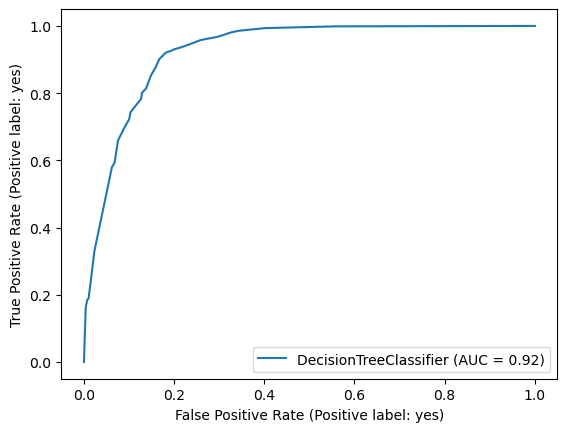

In [30]:
# Create ROC curve object and display it
roc_curve = plot_roc_curve(classTree, X_valid, y_valid)
plt.show()

In [31]:
#Calculate false positive and true positive rate for final comparision between each model using ROC Curve
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the valid set
y_prob_dt = classTree.predict_proba(X_valid)[:,1]
# Compute the false positive rate and true positive rate
#Decision Tree
fpr_dt, tpr_dt, thresholds = roc_curve(y_valid, y_prob_dt, pos_label='yes')
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_dt

0.9249215684876257

In [32]:
# Extract accuracy score for plotting later on
acc_ct = accuracy_score(y_valid, y_pred).round(2)
acc_ct

0.87

# Logistic Regression

In [33]:
cat_vars1 = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
bank_df = pd.get_dummies(final_df, columns=cat_vars)

In [34]:
# Split data into training and testing sets
X = bank_df.drop(['y'], axis=1)
y = bank_df['y']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

In [35]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [36]:
# Define the hyperparameters to search over
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10],
              'solver': ['liblinear'],
              'max_iter': [100, 500, 1000]}

In [37]:
# Create logistic regression model and fit to training data using GridSearchCV
lr_model = LogisticRegression()
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [100, 500, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [38]:
# Print the best hyperparameters and the corresponding accuracy score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.8667386609071276


In [39]:
# Create a new logistic regression model with the best hyperparameters and fit to training data
lr_model = LogisticRegression(**grid_search.best_params_)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=1, solver='liblinear')

In [40]:
# Make predictions on test data
y_pred = lr_model.predict(X_valid_scaled)

In [41]:
# Calculate accuracy score and print classification report
acc_score = accuracy_score(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred, zero_division=1)
print('Accuracy Score:', acc_score)
print('\nClassification Report:\n', class_report)

Accuracy Score: 0.8510362694300518

Classification Report:
               precision    recall  f1-score   support

          no       0.86      0.84      0.85      1547
         yes       0.84      0.87      0.85      1541

    accuracy                           0.85      3088
   macro avg       0.85      0.85      0.85      3088
weighted avg       0.85      0.85      0.85      3088



In [42]:
# Calculate accuracy score with a confusion matrix
classificationSummary(y_valid, y_pred)

Confusion Matrix (Accuracy 0.8510)

       Prediction
Actual    0    1
     0 1293  254
     1  206 1335


In [43]:
# Get predicted probabilities for test data
y_pred_prob = lr_model.predict_proba(X_valid_scaled)[:, 1]

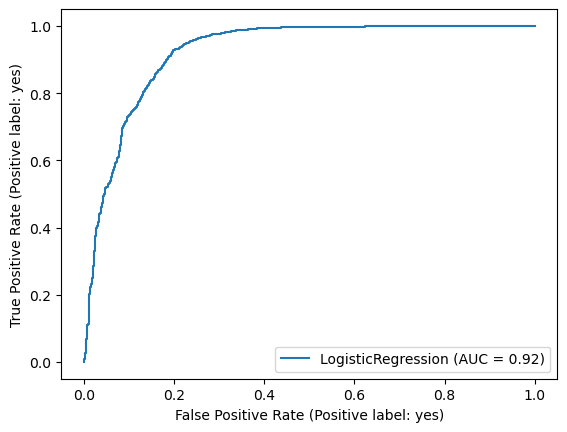

In [44]:
# Create ROC curve object and display it
roc_curve = plot_roc_curve(lr_model, X_valid_scaled, y_valid)
plt.show()

In [45]:
#Calculate false positive and true positive rate for final comparision between each model using ROC Curve

from sklearn.metrics import roc_curve, auc

# Predict probabilities on the valid set
y_prob_lr = lr_model.predict_proba(X_valid_scaled)[:,1]

# Compute the false positive rate and true positive rate
#logistic regression
fpr_lr, tpr_lr, thresholds = roc_curve(y_valid, y_prob_lr, pos_label='yes')
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lr

0.9235135975220718

In [46]:
# Extract accuracy score for plotting later on
acc_lr = accuracy_score(y_valid, y_pred).round(2)
acc_lr

0.85

# K-NN

In [47]:
# One-hot encoding for categorical variables
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
df_encoded = pd.get_dummies(final_df, columns=cat_vars)

In [48]:
# Split data into training and testing sets
X = df_encoded.drop(['y'], axis=1)
y = df_encoded['y']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

In [49]:
X_train.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'default_no', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_fa

In [50]:
results = []
for k in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    results.append({
        'k':k,
        'accuracy': accuracy_score(y_valid, knn.predict(X_valid))
    })

results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1  0.813472
1    2  0.795337
2    3  0.838407
3    4  0.827720
4    5  0.841321
5    6  0.836788
6    7  0.842940
7    8  0.844236
8    9  0.845207
9   10  0.841969
10  11  0.844883
11  12  0.841321
12  13  0.841645
13  14  0.841969


  One of the key points in the K-NN algorithm is knowing the ideal number of "K" to use. This parameter is used to chose the amount of nearest neighbours of the specific data being analyzed, and the model will determine its classification based on the biggest amount of a specific class among those nearest neighbors.<br><br>
  In the code above, different values of K were tested (from 1 to 14) using the training data, in order to check the best accuracy result. From the table above it is showed that k=9 has the best accuracy result, so that is the K value that will be used in the definitive model training, as it can be seen in the code below:

In [51]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

After training the model with the training part of the dataset, then the validation part of the dataset is applied into the model to get the classification prediction as the result:

In [52]:
y_pred = knn.predict(X_valid)

In [53]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

          no       0.87      0.82      0.84      1547
         yes       0.83      0.87      0.85      1541

    accuracy                           0.85      3088
   macro avg       0.85      0.85      0.85      3088
weighted avg       0.85      0.85      0.85      3088



In [54]:
classificationSummary(y_valid, y_pred)

Confusion Matrix (Accuracy 0.8452)

       Prediction
Actual    0    1
     0 1262  285
     1  193 1348


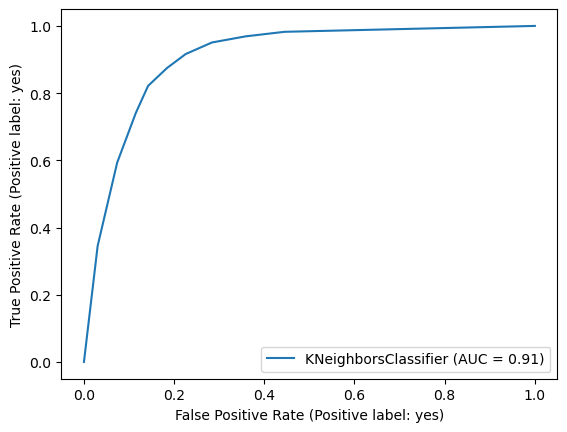

In [55]:
# Create ROC curve object and display it
roc_curve = plot_roc_curve(knn, X_valid, y_valid)
plt.show()

In [56]:
#Calculate false positive and true positive rate for final comparision between each model using ROC Curve
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate and true positive rate for all model
y_prob_knn = knn.predict_proba(X_valid)[:,1]

#Knn
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_valid, y_prob_knn, pos_label='yes')
roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_knn

0.9076282537175004

In [57]:
# Extract accuracy score for plotting later on
acc_knn = accuracy_score(y_valid, y_pred).round(2)
acc_knn

0.85

## NAIVE BAYES

In [58]:
data_nb = final_df.copy()

In [59]:
data_nb

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
6360,52,services,married,high.school,no,no,no,telephone,may,tue,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
16133,35,services,divorced,university.degree,no,no,yes,cellular,jul,tue,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,yes
40424,27,admin.,single,university.degree,no,yes,no,cellular,aug,fri,...,2,999,0,nonexistent,-1.7,94.027,-38.3,0.905,4991.6,yes
20638,35,technician,married,university.degree,no,yes,no,cellular,aug,wed,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,yes
37332,26,student,single,professional.course,no,yes,no,cellular,aug,tue,...,2,999,1,failure,-2.9,92.201,-31.4,0.883,5076.2,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11510,52,admin.,divorced,university.degree,no,yes,no,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
35901,50,admin.,divorced,university.degree,no,yes,yes,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,no
25447,35,technician,single,high.school,no,yes,yes,cellular,nov,wed,...,3,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,yes
7693,35,blue-collar,married,basic.6y,no,yes,no,telephone,may,fri,...,6,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,no


In [60]:
print(data_nb.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [61]:
#split the data into training (60%) and testing (40%)
predictors = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']

outcome = data_nb['y']

X = pd.get_dummies(data_nb[predictors]) #create dummy variables for predictors
y = data_nb['y']
classes = ['yes','no']

#split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# Use the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to all features in training data
scaler.fit(X_train)

# Apply the scaler to the features in the training and validation data
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [62]:
# Define the output labels
output_labels = {0: 'No', 1: 'Yes'}

# Run Multinomial Naive Bayes
data_nb = MultinomialNB()
data_nb.fit(X_train_scaled, y_train)  # Pass the scaled training data

# Predict probabilities of each record to its class
predProb_train = data_nb.predict_proba(X_train_scaled)  # Pass the scaled training data
predProb_valid = data_nb.predict_proba(X_valid_scaled)  # Pass the scaled validation data

# Convert the predicted probabilities to pandas data frame as a check and for data visualization
train_df = pd.DataFrame(predProb_train, columns=classes)
valid_df = pd.DataFrame(predProb_valid, columns=classes)

# Predict class membership (shows the class instead of probability by selecting the class with the highest probability)
y_valid_pred = data_nb.predict(X_valid_scaled)  # Pass the scaled validation data
y_train_pred = data_nb.predict(X_train_scaled)  # Pass the scaled training data

# Map the predicted class values to the output labels
y_valid_pred_labels = pd.Series(y_valid_pred).map(output_labels)
y_train_pred_labels = pd.Series(y_train_pred).map(output_labels)

# Print the pandas data frames with the output labels
print("Train Data Prediction Probabilities:\n", train_df.head())
print("\n\nValidation Data Prediction Probabilities:\n", valid_df.head())


Train Data Prediction Probabilities:
         yes        no
0  0.439262  0.560738
1  0.960093  0.039907
2  0.953238  0.046762
3  0.948078  0.051922
4  0.881591  0.118409


Validation Data Prediction Probabilities:
         yes        no
0  0.009199  0.990801
1  0.909670  0.090330
2  0.045717  0.954283
3  0.680754  0.319246
4  0.373525  0.626475


In [63]:
#y_valid_pred_labels
y_train.head()

28434    yes
865       no
5121      no
4209     yes
20471     no
Name: y, dtype: object

The above is the construction of the multinomial Naive Bayes algorithm on training data and validation data, which is split 60% for training and 40% for validation. It runs on scaled training data to obtain the probabilities of each record in both classes. Then the probabiliites are converted into pandas data frames to visualize and check the data, then using the predict() method, the class of each record is predicted. The output reflect the first five rows for both training and validation data, which again reflects the probability of each record belonging to their respective class.

In [64]:
classificationSummary(y_valid, y_valid_pred)

Confusion Matrix (Accuracy 0.7147)

       Prediction
Actual    0    1
     0 1223  324
     1  557  984


In [65]:
print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

          no       0.69      0.79      0.74      1547
         yes       0.75      0.64      0.69      1541

    accuracy                           0.71      3088
   macro avg       0.72      0.71      0.71      3088
weighted avg       0.72      0.71      0.71      3088



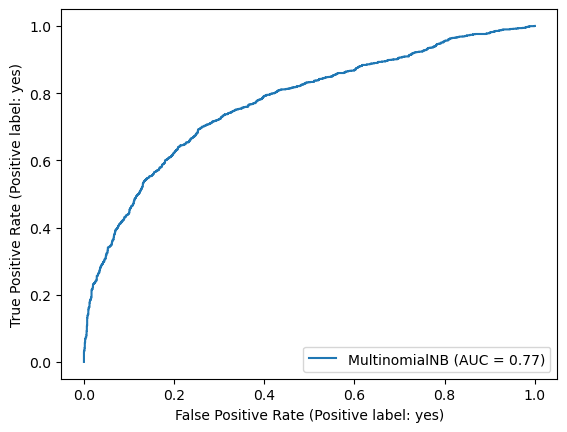

In [66]:
# Create ROC curve object and display it
# Plot ROC curve for Naive Bayes Model
plot_roc_curve(data_nb, X_valid_scaled, y_valid)
plt.show()

In [67]:
#Calculate false positive and true positive rate for final comparision between each model using ROC Curve

# Predict probabilities on the valid set
y_prob_nb = data_nb.predict_proba(X_valid_scaled)[:,1]

# Compute the false positive rate and true positive rate for
#Naive Bayes
fpr_nb, tpr_nb, thresholds = roc_curve(y_valid, y_prob_nb, pos_label='yes')
roc_auc_nb = auc(fpr_nb, tpr_nb)
roc_auc_nb

0.7730463223076881

In [68]:
# Extract accuracy score for plotting later on
acc_nb = accuracy_score(y_valid, y_valid_pred).round(2)
acc_nb

0.71

### Discriminant Analysis 

In [69]:
# Perform label encoding for categorical features
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
DA_bank_df = pd.get_dummies(final_df, columns=cat_vars)

In [70]:
# Split data into training and testing sets
X = DA_bank_df.drop(['y'], axis=1)
y = DA_bank_df['y']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

In [71]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fit LDA model to training data
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_valid)


In [73]:
# Make predictions on testing data
y_pred = lda.predict(X_valid)
y_pred

array(['yes', 'no', 'yes', ..., 'yes', 'yes', 'no'], dtype='<U3')

In [74]:
result = pd.DataFrame({'Predicted': y_pred, 'Actual': y_valid})
print(result.sample(10))

      Predicted Actual
27532        no     no
7359         no    yes
26254        no     no
34229        no     no
38751       yes    yes
31700       yes    yes
37815       yes     no
36601       yes    yes
10497        no     no
39866       yes    yes


In [75]:
# Define the actual and predicted labels
y_actual = result['Actual']
y_predicted = result['Predicted']

In [76]:
# Create the confusion matrix
classification_Summary = classificationSummary(y_actual, y_predicted)
print(classification_Summary)

Confusion Matrix (Accuracy 0.8300)

       Prediction
Actual    0    1
     0 1303  244
     1  281 1260
None


In [77]:
report = classification_report(y_actual,y_predicted)
print(report)

              precision    recall  f1-score   support

          no       0.82      0.84      0.83      1547
         yes       0.84      0.82      0.83      1541

    accuracy                           0.83      3088
   macro avg       0.83      0.83      0.83      3088
weighted avg       0.83      0.83      0.83      3088



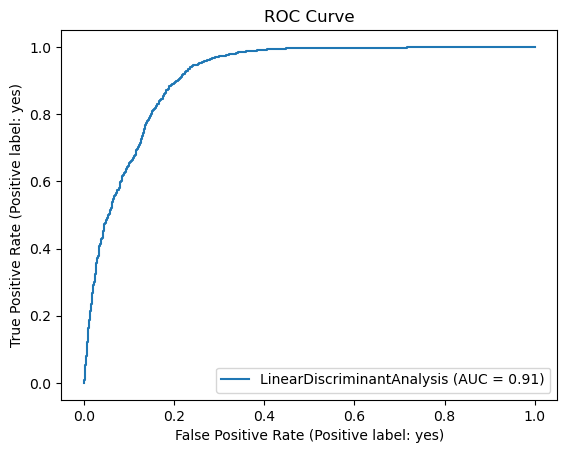

In [78]:
# Create ROC curve plot
plot_roc_curve(lda, X_valid, y_valid)
plt.title('ROC Curve')
plt.show()

In [79]:
# Predict probabilities on the valid set
y_prob_lda = lda.predict_proba(X_valid)[:,1]
# Compute the false positive rate and true positive rate
#linear Discriminant analysis 
fpr_lda, tpr_lda, thresholds = roc_curve(y_valid, y_prob_lda, pos_label='yes')
roc_auc_lda = auc(fpr_lda, tpr_lda)


In [80]:
# Extract accuracy score for plotting later on
acc_lda = accuracy_score(y_valid, y_pred).round(2)
acc_lda

0.83

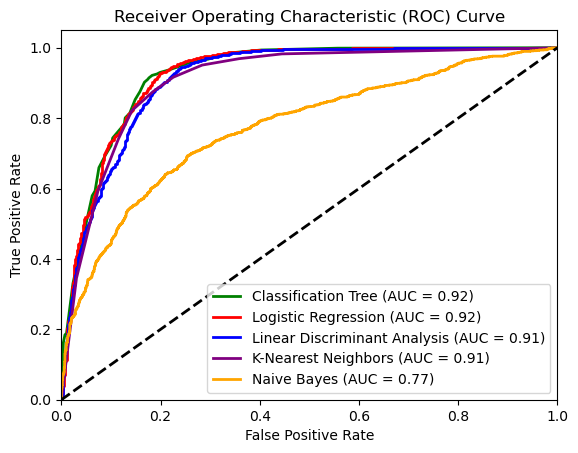

In [107]:
# Using false positive and true positive rate in each classifier, plot the final ROC curves to compare performance accuracy among them 
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label='Classification Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_lda, tpr_lda, color='blue', lw=2, label='Linear Discriminant Analysis (AUC = %0.2f)' % roc_auc_lda)
plt.plot(fpr_knn, tpr_knn, color='purple', lw=2, label='K-Nearest Neighbors (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_nb, tpr_nb, color='orange', lw=2, label='Naive Bayes (AUC = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [108]:
# set up data for plotting accuracy scores of all models
acc_scores = {'Classification Tree': acc_ct, 'Logistic Regression': acc_lr, 'Linear Discriminant Analysis': acc_lda,
                   'K-Nearest Neighbors': acc_knn, 'Naive Bayes': acc_nb}

# sorted data in descending order
sorted_acc_scores = {k: v for k, v in sorted(acc_scores.items(), key=lambda item: item[1], reverse=True)}
sorted_acc_scores

{'Classification Tree': 0.87,
 'Logistic Regression': 0.85,
 'K-Nearest Neighbors': 0.85,
 'Linear Discriminant Analysis': 0.83,
 'Naive Bayes': 0.71}

[Text(0, 0, '0.87'),
 Text(0, 0, '0.85'),
 Text(0, 0, '0.85'),
 Text(0, 0, '0.83'),
 Text(0, 0, '0.71')]

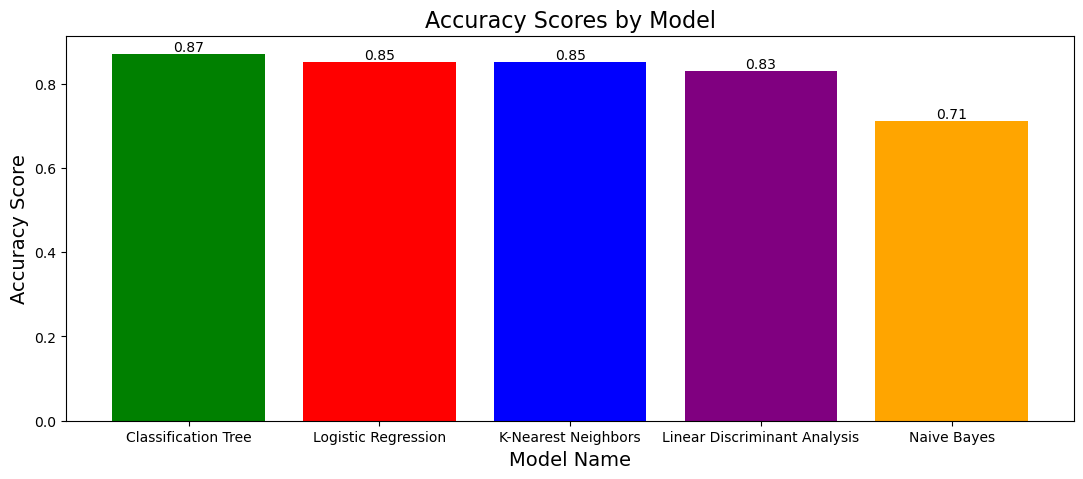

In [109]:
# Plot accuracy scores of all models using a bar chart
fig, ax = plt.subplots(figsize = (13,5))
bars = ax.bar(sorted_acc_scores.keys(), sorted_acc_scores.values(), color=['green', 'red', 'blue', 'purple', 'orange'])
ax.set_xlabel('Model Name', fontsize = 14)
ax.set_ylabel('Accuracy Score', fontsize = 14)
ax.set_title('Accuracy Scores by Model', fontsize = 16)
ax.bar_label(bars)